# Проверка системы сплитования

Перед проведением полноценных тестов, надо убедиться, что системам работает корректно.

Для проверки системы сплитования выполним следующие задачи:

1. Сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации сформируем подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

2. Построить гистограмму распределения получившихся 10000 p-values.

3. Посчитать, какой процент p values оказался меньше либо равен 0.05

4. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

In [9]:
#Импортируем библиотеки
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats
import numpy as np

#подключаемся к нужной схеме данных
connection = {'Здесь были данные для подключения'
}

#Задаем размер графика
sns.set(rc={'figure.figsize':(15,10)})



In [2]:
#Выгружаем нужные данные
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20231113.feed_actions 
WHERE toDate(time) between '2023-10-18' and '2023-10-24'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)


ау нас есть данные А/А-теста с '2023-10-18' по '2023-10-24'. Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

In [3]:
def aa_test_10000():
    pval_general = []
    for _ in range(10000): 
        var = df.sample(500, replace=False)
        pval_general.append(stats.ttest_ind(var[var.exp_group == 2].ctr, 
                                             var[var.exp_group == 3].ctr, 
                                             equal_var=False)[1])
    return np.array(pval_general)
    


In [4]:
pval_general = aa_test_10000()


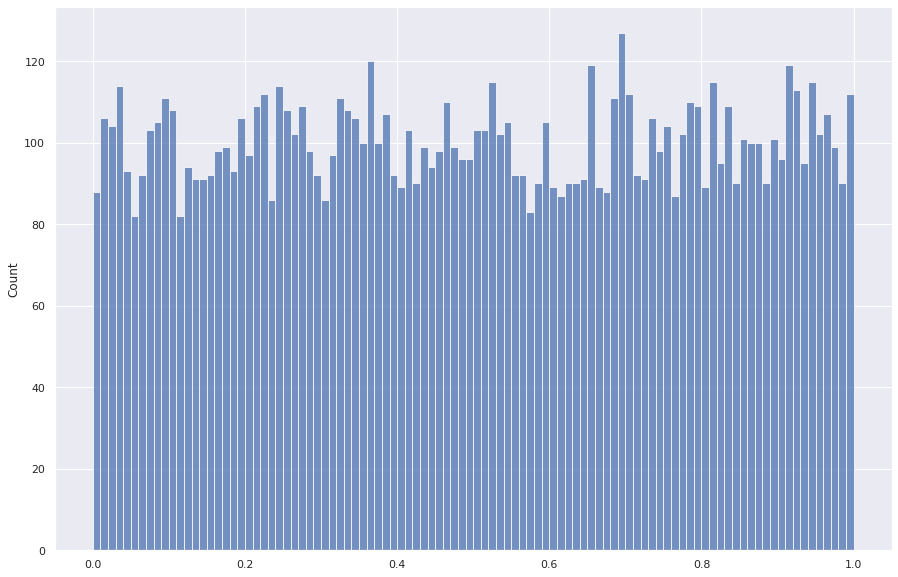

In [8]:
sns.histplot(data = pval_general, bins=100);

In [10]:
print(f"p-value меньше 0,05 в {np.mean(pval_general <= 0.05) * 100}%")

p-value меньше 0,05 в 5.04%


### Выводы

1. Визуально, по графику мы уже наблюдаем, что p-value в диапазоне < 0.05 занимает небольшую часть графика. Однако, в данном случае одними "глазами" окончательное решение принимать не стоит.

2. По рассчетам, количество p-value в диапазоне < 0.05 находится в районе ~5%, что демонстрирует корректную работу системы.

### Таким образом, работу системы можно признать корректной.